In [23]:
import numpy as np
import pandas as pd

# 2センサ(2列) + ラベル(3列目)
# 正常→平均シフト→正常→ばらつき変化→正常（分布: 正規分布）
def make_mmd_data(n_train=1000, seg=(400,250,300,250,400), seed=0,
                  mu=(0.0, 0.0), sig=(1.0, 1.0), rho=0.6,
                  mean_shift=(0.8, 0.0), var_mult=(1.0, 0.8)):
    """
    ラベル:
      0=正常, 1=平均シフト, 2=ばらつき変化

    mean_shift と var_mult が「2つ」ある理由：
      2センサ（s1, s2）なので「各センサごと」にドリフト量を指定できるため。
      mean_shift = (s1用, s2用) … 平均シフト区間での“平均の加算量”
      var_mult   = (s1用, s2用) … ばらつき変化区間での“標準偏差の倍率”
    """
    rng = np.random.default_rng(seed)
    mu  = np.array(mu, float)
    sig = np.array(sig, float)

    # 相関行列 → 共分散行列（標準偏差 sig を反映）
    r = float(np.clip(rho, -0.999, 0.999))
    C = np.array([[1.0, r],
                  [r,  1.0]], float)
    D = np.diag(sig)
    cov = D @ C @ D  # cov[i,i]=sig_i^2, cov[i,j]=rho*sig_i*sig_j

    def samp(n, mu_, cov_):
        return rng.multivariate_normal(mu_, cov_, size=n)

    # train（正常のみ：label=0）
    Xtr = samp(n_train, mu, cov)
    df_train = pd.DataFrame(np.c_[Xtr, np.zeros(n_train, int)], columns=["s1","s2","label"])

    # test（5区間を連結）
    n0,n1,n2,n3,n4 = seg
    X0 = samp(n0, mu, cov)                                  # 正常(0)

    # 平均シフト(1)：平均を「加算」でズラす（全体の中心が動く）
    mu1 = mu + np.array(mean_shift, float)
    X1 = samp(n1, mu1, cov)                                 # 平均シフト(1)
    X2 = samp(n2, mu, cov)                                  # 正常(0)
    # ばらつき変化(2)：標準偏差を倍率で変更（平均は維持）
    Dm   = np.diag(np.array(var_mult, float))               # 標準偏差倍率
    cov3 = Dm @ cov @ Dm                                    # 共分散を拡大/縮小
    X3 = samp(n3, mu, cov3)                                 # ばらつき変化(2)
    X4 = samp(n4, mu, cov)                                  # 正常(0)

    Xte = np.vstack([X0,X1,X2,X3,X4])

    y = np.concatenate([
        np.zeros(n0,int), np.ones(n1,int), np.zeros(n2,int),
        np.full(n3,2,int), np.zeros(n4,int)
    ])  # 0=正常, 1=平均シフト, 2=ばらつき変化

    df_test = pd.DataFrame(np.c_[Xte, y], columns=["s1","s2","label"])
    return df_train, df_test


# ============================================================
# 実行例
# ============================================================
# df_train : 学習用の参照データ（すべて label=0）
# df_test  : 時系列テスト（正常→平均シフト→正常→ばらつき変化→正常）
# label の意味: 0=正常, 1=平均シフト, 2=ばらつき変化
#
# seg を変えると各区間の長さを調整できる（例: (500,200,500,200,500)）
#
# mean_shift と var_mult が「2つ」ある理由：
#   2センサ（s1, s2）なので「各センサごと」にドリフト量を指定できるため。
#   mean_shift = (s1用, s2用) … 平均シフト区間での“平均の加算量”
#   var_mult   = (s1用, s2用) … ばらつき変化区間での“標準偏差の倍率”
#
# 例1) 両センサ同じドリフト量にする：
#   mean_shift=(0.5, 0.5)
#   var_mult=(0.8, 0.8)
#
# 例2) 片方だけドリフトさせる：
#   mean_shift=(0.8, 0.0)   # s1だけ平均シフト
#   var_mult=(1.0, 0.8)     # s2だけばらつき変化
# ============================================================
df_train, df_test = make_mmd_data(
    n_train=2000,
    seg=(700, 400, 500, 600, 400),
    seed=0,
    mu=(0.0, 0.0),
    sig=(1.0, 1.0),
    rho=0.6,
    mean_shift=(0.5, 0.0),
    var_mult=(1.0, 1.4)
)

print(df_train.shape, df_test.shape)



(2000, 3) (2600, 3)


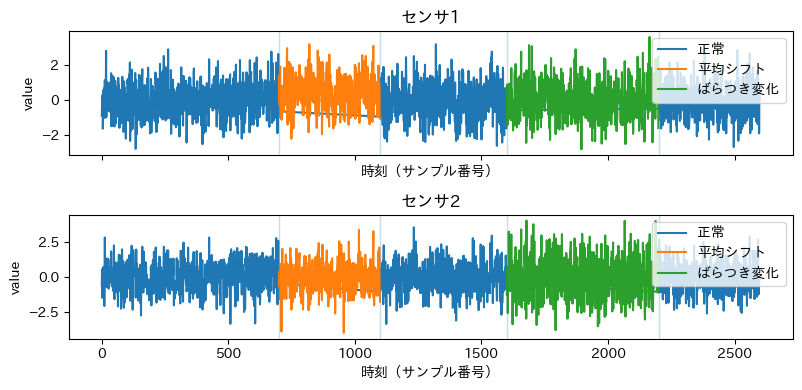

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# ============================================================
# テストデータをプロット（2タイル横長 / ラベルで色分け）
# ============================================================
t = np.arange(len(df_test))
labels = df_test["label"].astype(int).to_numpy()
label_name = {0: "正常", 1: "平均シフト", 2: "ばらつき変化"}

# 区間境界（縦線で分かりやすく）
change_idx = np.where(labels[1:] != labels[:-1])[0] + 1
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

for ax, col, title in zip(axes, ["s1", "s2"], ["センサ1", "センサ2"]):
    y = df_test[col].to_numpy()

    # ラベルごとに点を色分け（matplotlibのデフォルト色を利用）
    for lab in sorted(np.unique(labels)):
        m = labels == lab
        ax.plot(t[m], y[m], label=label_name.get(lab, str(lab)))

    for x in change_idx:
        ax.axvline(x, linewidth=1.0, alpha=0.25)

    ax.set_title(title)
    ax.set_xlabel("時刻（サンプル番号）")
    ax.set_ylabel("value")
    ax.legend(loc="upper right", frameon=True)

fig.tight_layout()
plt.show()

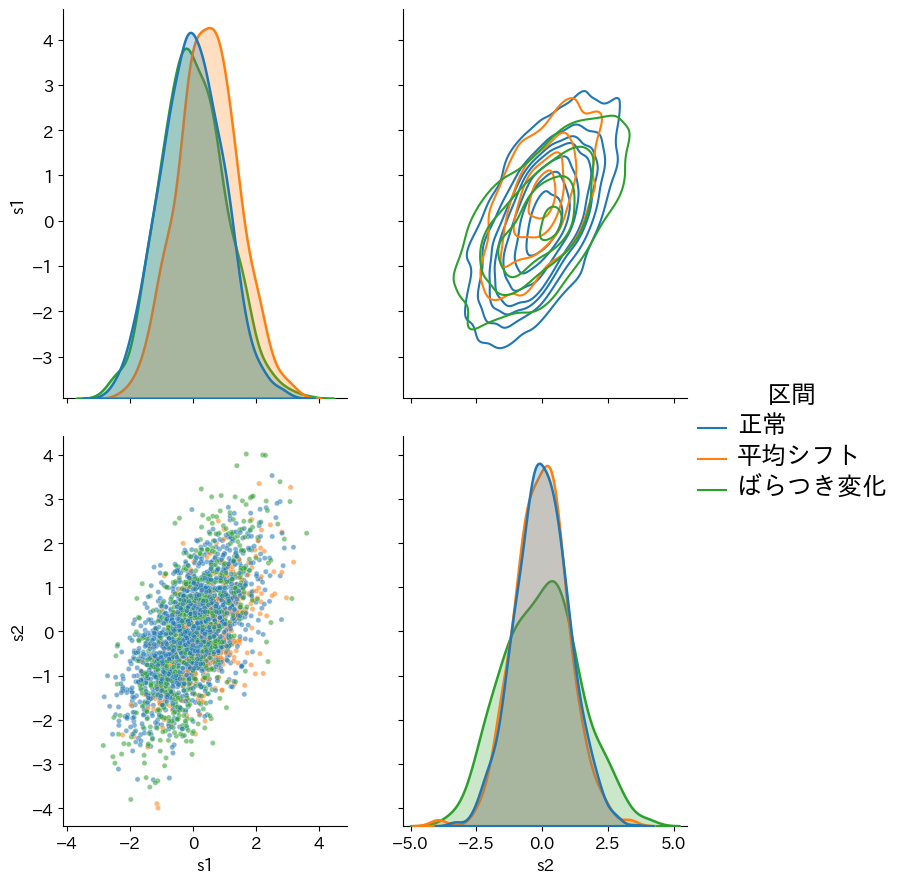

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語が□になる場合に有効

# df_test がある前提（make_mmd_data() を実行済み）
dfp = df_test[["s1", "s2", "label"]].copy()
dfp["区間"] = dfp["label"].map({0: "正常", 1: "平均シフト", 2: "ばらつき変化"})

# ============================================================
# ペアプロット（散布図 + KDE比較）
# - 左下：散布図（点群の見え方）
# - 右上：2次元KDE等高線（密度の形）
# - 対角：1次元KDE（各変数の分布）
# ============================================================
# フォントサイズ（ここだけ）
FS_AXIS = 12   # 軸ラベル
FS_TICK = 12   # 目盛り
FS_LEG  = 18   # 凡例

g = sns.PairGrid(dfp, vars=["s1", "s2"], hue="区間", corner=False)
g.map_diag(sns.kdeplot, fill=True, common_norm=False, linewidth=1.8)
g.map_lower(sns.scatterplot, s=14, alpha=0.55, edgecolor="w", linewidth=0.3)
g.map_upper(sns.kdeplot, levels=8, fill=False, thresh=0.05, linewidths=1.5)
g.add_legend(title="区間")
g.fig.set_size_inches(9.5, 9.5)

for ax in g.axes.flatten():
    if ax:
        ax.set_xlabel(ax.get_xlabel(), fontsize=FS_AXIS)
        ax.set_ylabel(ax.get_ylabel(), fontsize=FS_AXIS)
        ax.tick_params(labelsize=FS_TICK)
if g._legend:
    g._legend.set_title("区間", prop={"size": FS_LEG})
    for t in g._legend.texts:
        t.set_fontsize(FS_LEG)

plt.show()


In [26]:
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDriftOnline

# -----------------------------
# 入力行列を作る（参照=学習データ、テスト=監視データ）
# -----------------------------
X_ref  = df_train[["s1", "s2"]].to_numpy().astype(np.float32)
X_test = df_test[["s1", "s2"]].to_numpy().astype(np.float32)
y_test = df_test["label"].to_numpy().astype(int)

# -----------------------------
# 前処理：標準化（重要）
#   - 参照（正常）で平均0・分散1に合わせる
#   - 同じ変換をテストにも適用
# -----------------------------
scaler = StandardScaler()
X_ref_std  = scaler.fit_transform(X_ref).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

# -----------------------------
# Alibi Detect: Online MMD（最小設定）
# -----------------------------
window_size = 50
ert = 500.0
n_bootstraps = 5000  # 目安: ert の10倍程度（閾値の安定化のため）

cd = MMDDriftOnline(
    x_ref=X_ref_std,
    ert=ert,
    window_size=window_size,
    backend="tensorflow",
    n_bootstraps=n_bootstraps,
    verbose=True
)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [07:35<00:00,  9.12s/it]


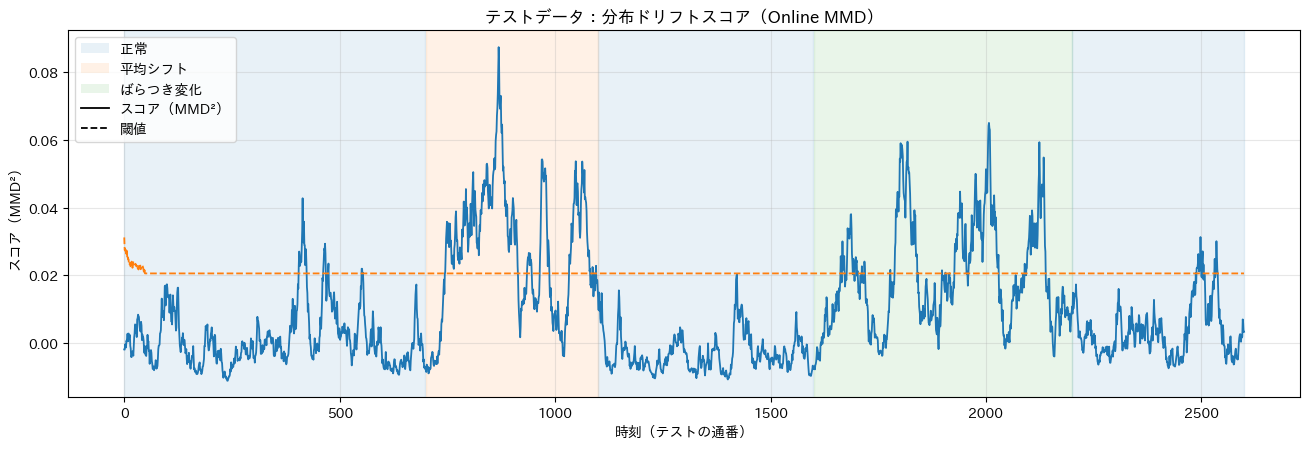

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ============================================================
# スコア算出（テストを1点ずつ流してログ化）
# ============================================================
n = X_test_std.shape[0]
mmd2 = np.full(n, np.nan, dtype=float)
thr  = np.full(n, np.nan, dtype=float)
is_drift = np.zeros(n, dtype=int)

for i in range(n):
    out = cd.predict(X_test_std[i], return_test_stat=True)
    d = out["data"]
    mmd2[i] = float(d.get("test_stat", np.nan))
    thr[i]  = float(d.get("threshold", np.nan))
    is_drift[i] = int(d.get("is_drift", 0))

df_log_test = pd.DataFrame({
    "i": np.arange(n),
    "mmd2": mmd2,
    "threshold": thr,
    "is_drift": is_drift,
    "label": y_test[:n],
})

# ============================================================
# 可視化：スコア波形 + 閾値 + 閾値超えマーカー + ラベルで背景色
# ============================================================
label_name  = {0: "正常", 1: "平均シフト", 2: "ばらつき変化"}
label_color = {0: "C0",   1: "C1",        2: "C2"}

t = df_log_test["i"].to_numpy()
y = df_log_test["label"].to_numpy()

fig, ax = plt.subplots(figsize=(13.2, 4.6))
ax.set_axisbelow(True)

# 背景をラベル区間で塗る（連続区間ごと）
change = np.flatnonzero(y[1:] != y[:-1]) + 1
bounds = np.r_[0, change, len(y)]
for k in range(len(bounds) - 1):
    a, b = bounds[k], bounds[k + 1]
    lab = int(y[a])
    ax.axvspan(t[a], t[b - 1], alpha=0.10, color=label_color.get(lab, "0.8"), zorder=0)

# スコアと閾値
ax.plot(t, df_log_test["mmd2"].to_numpy(), linewidth=1.3, label="スコア（MMD²）", zorder=2)
ax.plot(t, df_log_test["threshold"].to_numpy(), linestyle="--", linewidth=1.3, label="閾値", zorder=2)

ax.set_title("テストデータ：分布ドリフトスコア（Online MMD）")
ax.set_xlabel("時刻（テストの通番）")
ax.set_ylabel("スコア（MMD²）")
ax.grid(True, alpha=0.30)

# 凡例（背景色=区間ラベルも入れる）
handles = [
    Patch(facecolor=label_color[0], alpha=0.10, label=label_name[0]),
    Patch(facecolor=label_color[1], alpha=0.10, label=label_name[1]),
    Patch(facecolor=label_color[2], alpha=0.10, label=label_name[2]),
    Line2D([0],[0], color="k", linewidth=1.3, label="スコア（MMD²）"),
    Line2D([0],[0], color="k", linestyle="--", linewidth=1.3, label="閾値"),
]
ax.legend(handles=handles, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()